In [1]:
# import necessary modules
# uncomment to get plots displayed in notebook
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy_sz import Class
import math

Metal device set to: Apple M1 Pro


2023-04-06 15:32:14.741395: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-06 15:32:14.741508: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [2]:
font = {'size'   : 16, 'family':'STIXGeneral'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
plt.rcParams["figure.figsize"] = [8.0,8.0]


# a simple conversion from cl's to dl's
def l_to_dl(lp):
    return lp*(lp+1.)/2./np.pi

# Parameters 

Important: Planck 2014/ McCarthy et al. use Planck 2014 cosmology (https://arxiv.org/pdf/1303.5076.pdf, best-fit)

In [3]:
# # parameters for Cosmology Planck 14, https://arxiv.org/pdf/1303.5076.pdf, best-fit
p14_dict={}
p14_dict['Omega_cdm'] = 0.3175-0.022068/0.6711/0.6711
p14_dict['omega_b'] = 0.022068
p14_dict['h'] = 0.6711
p14_dict['A_s'] = 2.2e-9
p14_dict['n_s'] = .9624
p14_dict['k_pivot'] = 0.05
p14_dict['tau_reio'] = 0.0925

p14_dict['N_ncdm'] = 1
p14_dict['N_ur'] = 0.00641
p14_dict['deg_ncdm'] = 3
p14_dict['m_ncdm'] = 0.02
p14_dict['T_ncdm'] = 0.71611



# benchmark
p_dict = {}
p_dict['mass function'] = 'T10' # // note that alpha is computed at each z.
p_dict['concentration parameter'] = 'D08'
p_dict['delta for cib'] = '200m'
p_dict['hm_consistency'] = 0
p_dict['damping_1h_term'] = 0

# mass bounds
p_dict['M_min'] = 1e8*p14_dict['h'] # was M_min_cib
p_dict['M_max'] = 1e16*p14_dict['h'] # was M_max_cib
# redshift bounds
p_dict['z_min'] = 0.07
p_dict['z_max'] = 6. # fiducial for MM20 : 6

p_dict['freq_min'] = 200. # tabulation of Lsat in nu's
p_dict['freq_max'] = 600. # tabulation of Lsat in nu's

p_dict['n_z_L_sat'] = 100
p_dict['n_m_L_sat'] = 100
p_dict['n_nu_L_sat'] = 100


# HOD parameters for CIB
p_dict['M_min_HOD_cib'] = pow(10.,10) 



# CIB parametes see McCarthy & Madhavacheril 2020
p_dict['Redshift evolution of dust temperature'] =  0.36
p_dict['Dust temperature today in Kelvins'] = 24.4
p_dict['Emissivity index of sed'] = 1.75
p_dict['Power law index of SED at high frequency'] = 1.7
p_dict['Redshift evolution of L − M normalisation'] = 3.6
p_dict['Most efficient halo mass in Msun'] = pow(10.,12.6)
p_dict['Normalisation of L − M relation in [Jy MPc2/Msun]'] = 6.4e-8
p_dict['Size of of halo masses sourcing CIB emission'] = 0.5


# precision for redshift integal
p_dict['redshift_epsabs'] = 1e-40#1.e-40
p_dict['redshift_epsrel'] = 1e-4#1.e-10 # fiducial value 1e-8
# precision for mass integal
p_dict['mass_epsabs'] = 1e-40 #1.e-40
p_dict['mass_epsrel'] = 1e-4#1e-10
# precision for Luminosity integral (sub-halo mass function)
p_dict['L_sat_epsabs'] = 1e-40 #1.e-40
p_dict['L_sat_epsrel'] = 1e-6#1e-10

# multipole array
p_dict['dlogell'] = 0.5
p_dict['ell_max'] = 8000.
p_dict['ell_min'] = 2.


# Select frequencies 

In [4]:
nu_list = 217,353,545
nu_list_str = '217,353,545'

Don't forget to adjust the freq_min and freq_max parameters if you want to look 
at frequencies outside this range!

## Flux cut 

In [5]:
# flux cut values

cib_flux = {}
# Planck flux cut, Table 1 in https://arxiv.org/pdf/1309.0382.pdf
cib_flux['100'] = 400
cib_flux['143'] = 350
cib_flux['217'] = 225
cib_flux['353'] = 315
cib_flux['545'] = 350
cib_flux['857'] = 710
cib_flux['3000'] = 1000
#SO, from SO foreacst
cib_flux['93'] = 7
cib_flux['145'] = 15
cib_flux['225'] = 20
cib_flux['280'] = 25
#CCAT prime, McCarthy et al.'s' assumptions
# cib_flux['93'] = 400
# cib_flux['145'] = 350
# cib_flux['225'] = 225
# cib_flux['220'] = 225
# cib_flux['280'] = 225
# cib_flux['350'] = 315
# cib_flux['550'] = 350
# cib_flux['545'] = 350
# cib_flux['850'] = 710

def make_flux_cut_list(cib_flux_dict, nu_list):
    """
    Make a string of flux cut values for given frequency list to pass into class_sz
    Beware: if frequency not in the flux_cut dictionary, it assigns 0
    """
    cib_flux_list = []
    keys = list(cib_flux.keys())
    for i,nu in enumerate(nu_list):
        if str(nu) in keys:
            cib_flux_list.append(cib_flux[str(nu)])
        else:
            cib_flux_list.append(0)
    return cib_flux_list

cib_flux_list = make_flux_cut_list(cib_flux, nu_list)

# Compute CIB auto 

In [6]:
%%time
#Planck 2014/ McCarthy et al. 
N = Class()
N.set(p14_dict)
N.set(p_dict)

N.set({# class_sz parameters:
        'output':'cib_cib_1h,cib_cib_2h',
        'class_sz_verbose':0,
        'ndim_redshifts': 210,
        'ndim_masses':150,
        'cib_frequency_list_num' : len(nu_list),
        'cib_frequency_list_in_GHz' : nu_list_str,  
        'cib_Snu_cutoff_list [mJy]': str(list(cib_flux_list))[1:-1],
        'has_cib_flux_cut': 1
        })
        
N.compute()

CPU times: user 51.2 s, sys: 162 ms, total: 51.4 s
Wall time: 6.28 s


In [7]:
cib = N.cl_cib_cib()
ell_cib = np.asarray(cib[str(nu_list[0])+'x'+str(nu_list[0])]['ell'])

# Compare with other codes 

In [13]:
import os
path_to_class_sz = os.getcwd() +'/../../class_sz/'


In [14]:
# data MM2020 (obtained from the authors) https://arxiv.org/pdf/2010.16405.pdf
def read_mccarthy_auto(freq, path_to_class_sz):
    L_ref_1h = np.loadtxt(path_to_class_sz + 'class_sz_auxiliary_files/cib_files/cib_1h_'+str(int(freq))+'x'+str(int(freq))+'.txt')
    ell_MM20 = L_ref_1h[:,0]
    cib_1h_MM20 = L_ref_1h[:,1]
    L_ref_2h= np.loadtxt(path_to_class_sz + 'class_sz_auxiliary_files/cib_files/cib_2h_'+str(int(freq))+'x'+str(int(freq))+'.txt')
    cib_2h_MM20 = L_ref_2h[:,1]
    return ell_MM20, cib_1h_MM20, cib_2h_MM20 

ell_MM20_217, cib_1h_MM20_217, cib_2h_MM20_217 = read_mccarthy_auto(217, path_to_class_sz)
ell_MM20_353, cib_1h_MM20_353, cib_2h_MM20_353 = read_mccarthy_auto(353, path_to_class_sz)
ell_MM20_545, cib_1h_MM20_545, cib_2h_MM20_545 = read_mccarthy_auto(545, path_to_class_sz)

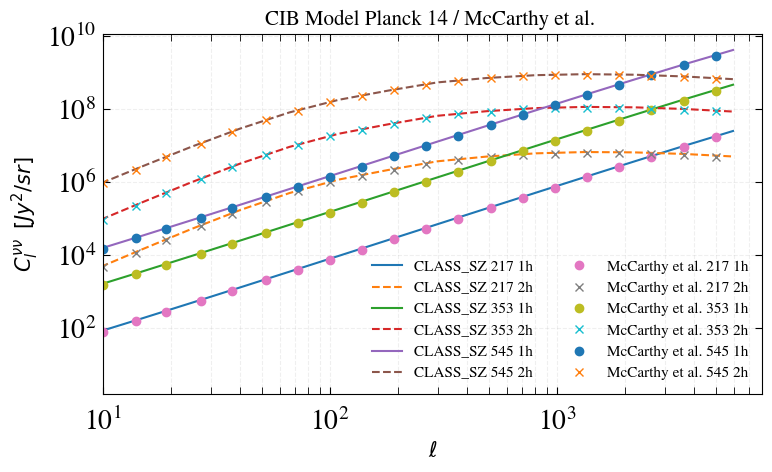

In [15]:
fig, ax1 = plt.subplots(1,1,figsize=(8,5))

m200c_arr = np.geomspace(1e10,1e15,50)

ax = ax1
ax.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
ax.tick_params(axis = 'y',which='both',length=5,direction='in', pad=5)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=12)
plt.setp(ax.get_xticklabels(), fontsize=12)
ax.grid( visible=True, which="both", alpha=0.2, linestyle='--')
ax.set_ylabel(r"$C_l^{\nu \nu} \,\,\, [Jy^2/sr]$", size=15)
ax.set_xlabel(r"$\ell$", size=15)
plt.title('CIB Model Planck 14 / McCarthy et al. ', fontsize=15)


for (i,nu) in enumerate(nu_list):
    cib_1h = np.asarray(cib[str(nu)+'x'+str(nu)]['1h']) 
    cib_2h = np.asarray(cib[str(nu)+'x'+str(nu)]['2h'])
    plt.plot(ell_cib, cib_1h, "-", label=r'CLASS_SZ %.1i 1h'%(nu))
    plt.plot(ell_cib, cib_2h, "--", label=r'CLASS_SZ %.1i 2h'%(nu))
    
plt.plot(ell_MM20_217, cib_1h_MM20_217,"o", label = "McCarthy et al. 217 1h")
plt.plot(ell_MM20_217, cib_2h_MM20_217,"x", label = "McCarthy et al. 217 2h")
plt.plot(ell_MM20_353, cib_1h_MM20_353,"o", label = "McCarthy et al. 353 1h")
plt.plot(ell_MM20_353, cib_2h_MM20_353,"x", label = "McCarthy et al. 353 2h")
plt.plot(ell_MM20_545, cib_1h_MM20_545,"o", label = "McCarthy et al. 545 1h")
plt.plot(ell_MM20_545, cib_2h_MM20_545,"x", label = "McCarthy et al. 545 2h")
   
plt.xlim(1.e1, 8.e3)
#plt.ylim(1e-4,0) 
plt.yscale("log")
plt.xscale("log")
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

plt.legend(loc=4,ncol=2, fontsize=11,frameon=False)

fig.tight_layout()
# plt.savefig('figures/shang_mccarthy_cib_cls.pdf')